**PROBLEM STATEMENT**

In this part, we will learn **to predict heart disease** based on this attribute here, and also dataset from [here](https://www.kaggle.com/andrewmvd/heart-failure-clinical-data):
1. age: age of the patient (years)
2. anaemia: decrease of red blood cells or hemoglobin (boolean)
3. high blood pressure: if the patient has hypertension (boolean)
4. creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
5. diabetes: if the patient has diabetes (boolean)
6. ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
7. platelets: platelets in the blood (kiloplatelets/mL)
8. sex: woman or man (binary)
9. serum creatinine: level of serum creatinine in the blood (mg/dL)
10. serum sodium: level of serum sodium in the blood (mEq/L)
11. smoking: if the patient smokes or not (boolean)
12. time: follow-up period (days)
13. death event: if the patient deceased during the follow-up period (boolean)

In [1]:
# import some useful library
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats
from collections import Counter
import pylab
from scipy.stats import norm, skew, boxcox

import warnings
warnings.filterwarnings("ignore")

In [2]:
# import dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/heart-failure-clinical-data

  0% 0.00/3.97k [00:00<?, ?B/s]
100% 3.97k/3.97k [00:00<00:00, 6.30MB/s]


In [3]:
!unzip "heart-failure-clinical-data.zip"

Archive:  heart-failure-clinical-data.zip
  inflating: heart_failure_clinical_records_dataset.csv  


In [4]:
df = pd.read_csv("heart_failure_clinical_records_dataset.csv")
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [7]:
print("Shape of dataset", df.shape)

Shape of dataset (299, 13)


## **EXPLORATION**

In [9]:
def plotnumerical(variable):
    print("min {} : {} ".format(variable, min(df[variable])))
    print("max {} : {}".format(variable, max(df[variable])))
       
    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.hist(df[variable], color="orange")
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist ".format(variable))

    plt.subplot(1,3,2)
    sns.distplot(df[variable], fit=norm)
    plt.title("{} distribution with Distplot ".format(variable))
    
    plt.subplot(1,3,3)
    stats.probplot(df[variable],dist='norm',plot=pylab)
    plt.title("{} distribution with Q-Q plot ".format(variable))

    plt.show();

In [22]:
def categoricalplot(variable):
    ax = sns.countplot(x=variable, data=df, palette='YlGnBu_r')
    for p in ax.patches:
      ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), size=10)
    plt.show();

min age : 40.0 
max age : 95.0


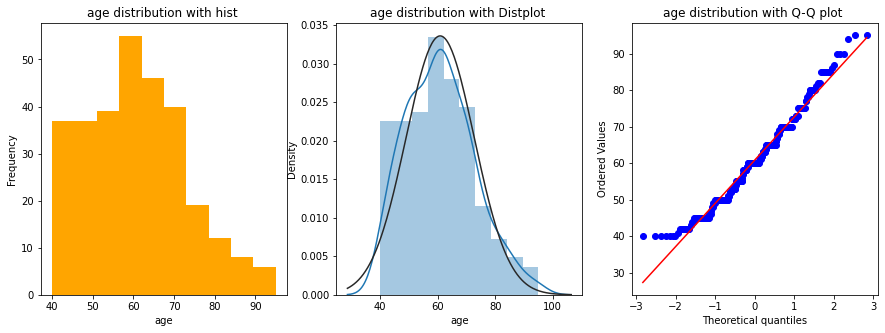

min creatinine_phosphokinase : 23 
max creatinine_phosphokinase : 7861


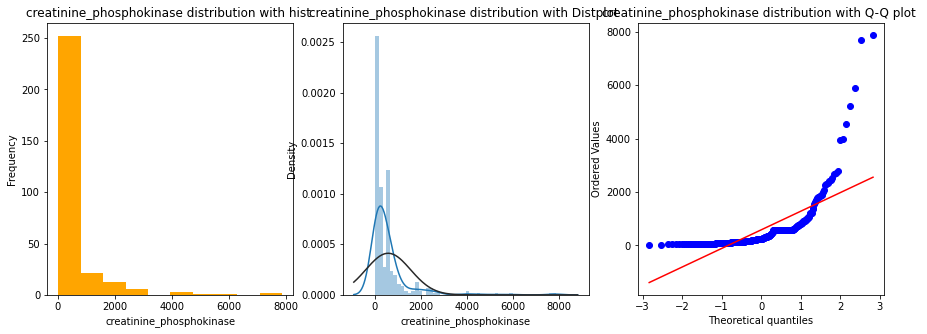

min ejection_fraction : 14 
max ejection_fraction : 80


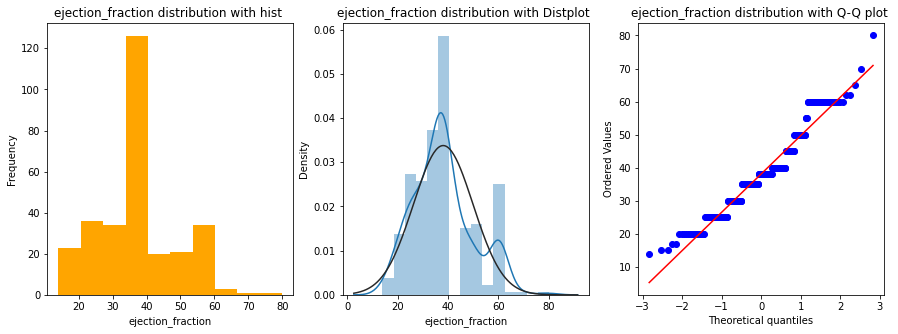

min platelets : 25100.0 
max platelets : 850000.0


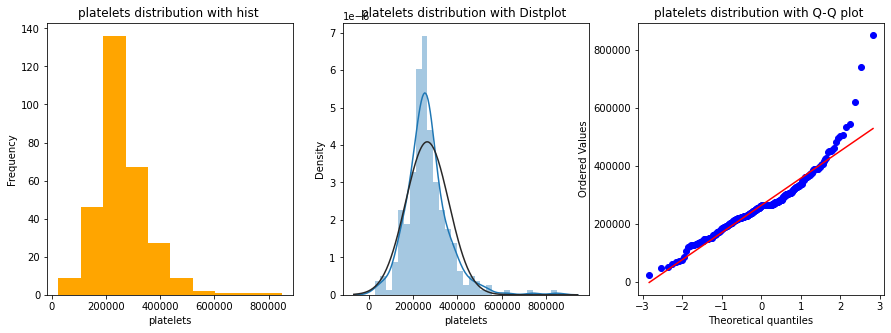

min serum_creatinine : 0.5 
max serum_creatinine : 9.4


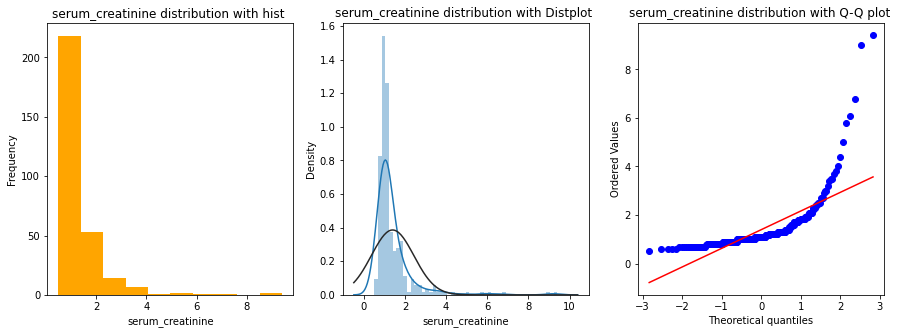

min serum_sodium : 113 
max serum_sodium : 148


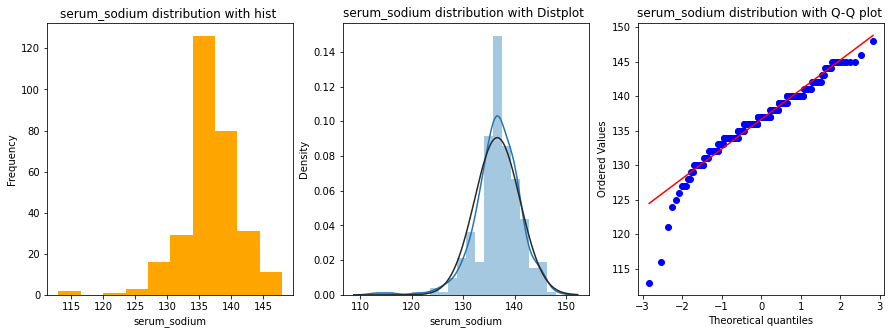

min time : 4 
max time : 285


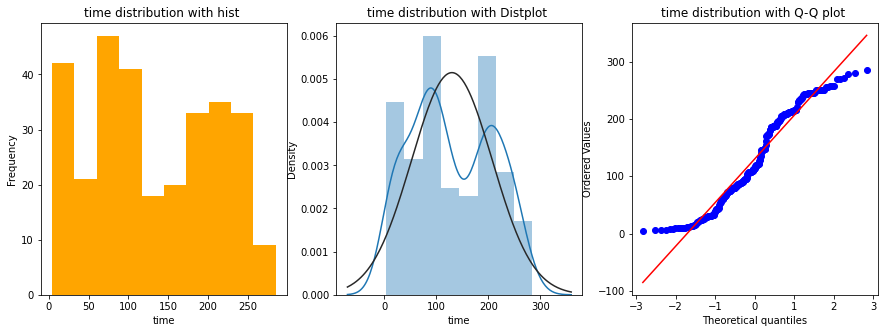

In [11]:
# NUMERICAL
numerical = ["age","creatinine_phosphokinase","ejection_fraction","platelets","serum_creatinine","serum_sodium","time"]
for i in numerical:
    plotnumerical(i)

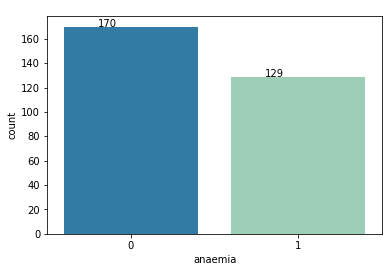

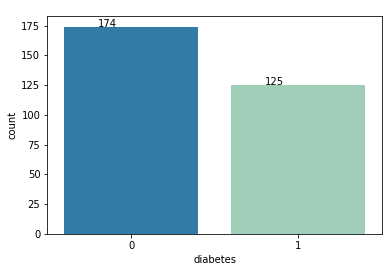

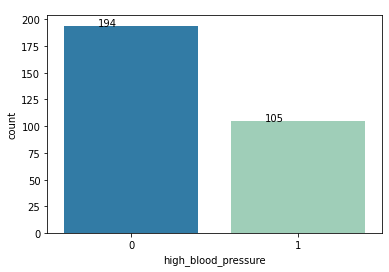

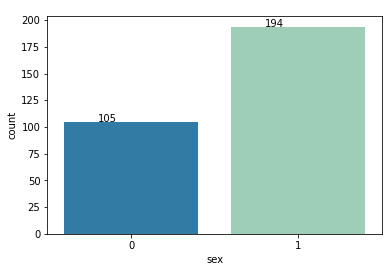

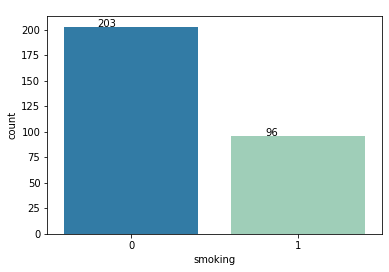

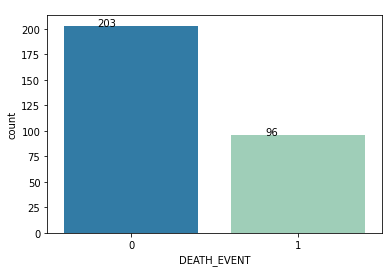

In [23]:
# CATEGORICAL
category = ["anaemia","diabetes","high_blood_pressure","sex","smoking","DEATH_EVENT"]
for c in category:
    categoricalplot(c)

In [24]:
# Outlier detection
def detect_outliers(df,features):
    outlier_indices = []
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3st quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier Step
        outlier_step = IQR * 1.5
        # detect outlier and their indeces
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # store indeces 
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 1) 
    
    return multiple_outliers

In [26]:
print("Data that outlier")
df.loc[detect_outliers(df,["age",
                           "creatinine_phosphokinase",
                           "ejection_fraction",
                           "platelets","serum_creatinine",
                           "serum_sodium","time"])]

Data that outlier


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
38,60.0,0,2656,1,30,0,305000.00,2.3,137,1,0,30,0
52,60.0,0,3964,1,62,0,263358.03,6.8,146,0,0,43,1
163,50.0,1,2334,1,35,0,75000.00,0.9,142,0,0,126,1
200,63.0,1,1767,0,45,0,73000.00,0.7,137,1,0,186,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
217,54.0,1,427,0,70,1,151000.00,9.0,137,0,0,196,1
117,85.0,1,102,0,60,0,507000.00,3.2,138,0,0,94,0
167,59.0,0,66,1,20,0,70000.00,2.4,134,1,0,135,1
281,70.0,0,582,0,40,0,51000.00,2.7,136,1,1,250,0
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [27]:
df = df.drop(detect_outliers(df,["age","creatinine_phosphokinase",
                                 "ejection_fraction","platelets",
                                 "serum_creatinine","serum_sodium",
                                 "time"]),
             axis = 0)\
             .reset_index(drop=True)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1


In [29]:
df.loc[detect_outliers(df,["age",
                           "creatinine_phosphokinase",
                           "ejection_fraction",
                           "platelets","serum_creatinine",
                           "serum_sodium","time"])]
print("No outlier in here")

No outlier in here


## **FEATURE ENGINEERING**

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64


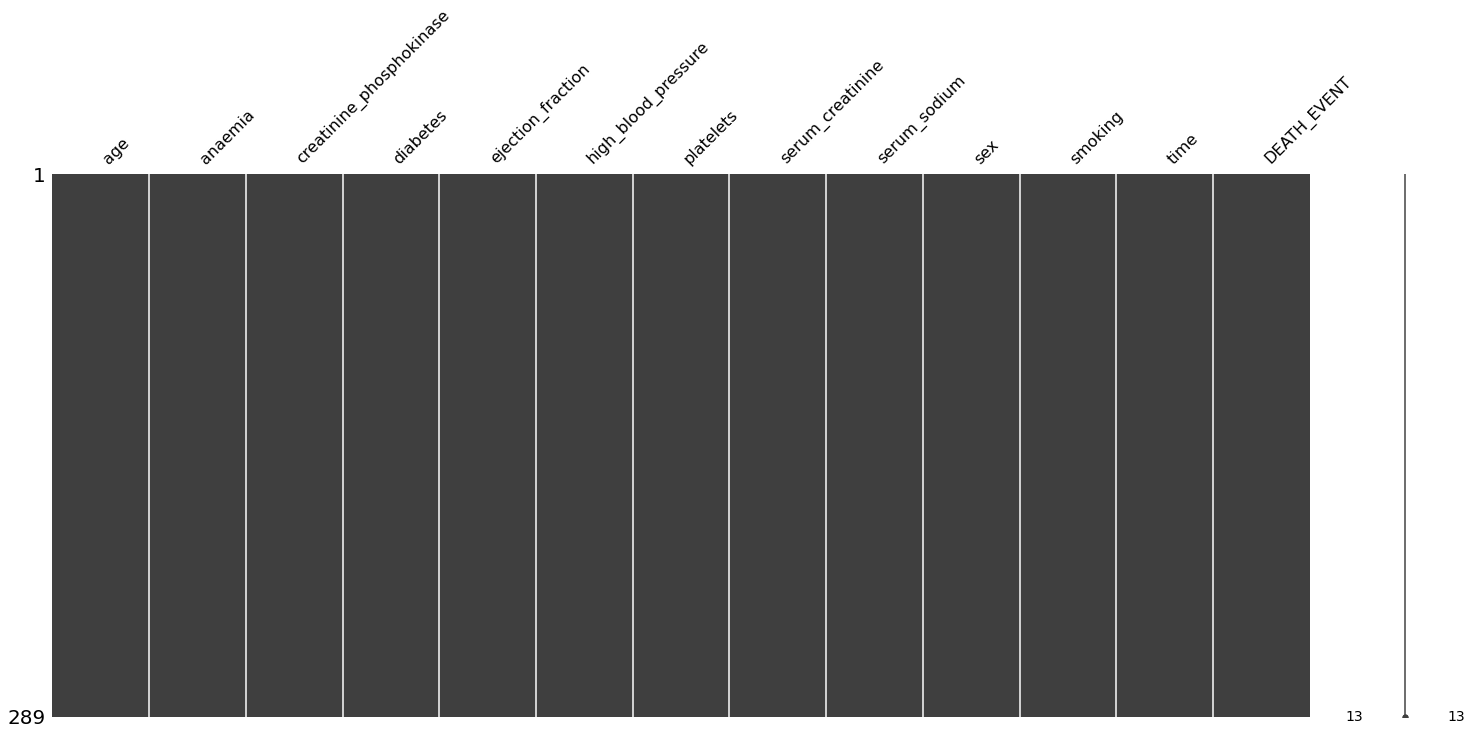

In [31]:
import missingno as msno
%matplotlib inline
msno.matrix(df)
print(df.isnull().sum());

In [30]:
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness

,skewed
creatinine_phosphokinase,4.827396
serum_creatinine,4.605615
platelets,1.429547
DEATH_EVENT,0.797132
smoking,0.729243
high_blood_pressure,0.583959
ejection_fraction,0.546146
age,0.413840
diabetes,0.358569
anaemia,0.286636


Right Skewed or Positive Skewed --> The distribution has a rightward tail with respect to the normal distribution.

In [32]:
# POSITIVE SKEW
skewness[skewness["skewed"]>1]

,skewed
creatinine_phosphokinase,4.827396
serum_creatinine,4.605615
platelets,1.429547


Left Skewed or Negative Skewed --> The distribution has a tail to the left relative to the normal distribution.

In [33]:
# NEGATIVE SKEW
skewness[skewness["skewed"]<-1]

,skewed


In [34]:
def plot_data(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    data[feature].hist()
    plt.subplot(1,2,2)
    stats.probplot(data[feature],dist='norm',plot=pylab)
    plt.show()

In [37]:
# DO SOME TRANSFORMATION
# BEFORE DATA
data=df.copy(deep=True)
before_Trans=[]
v1 = data["creatinine_phosphokinase"].skew()
before_Trans.append(v1)
v1 = data["serum_creatinine"].skew()
before_Trans.append(v1)
v1 = data["platelets"].skew()
before_Trans.append(v1)

# LOGARITHMIC
Log_Trans=[]

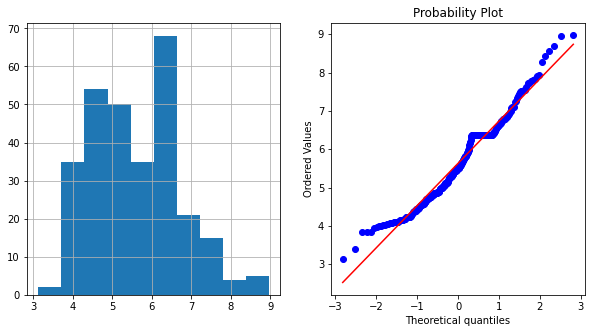

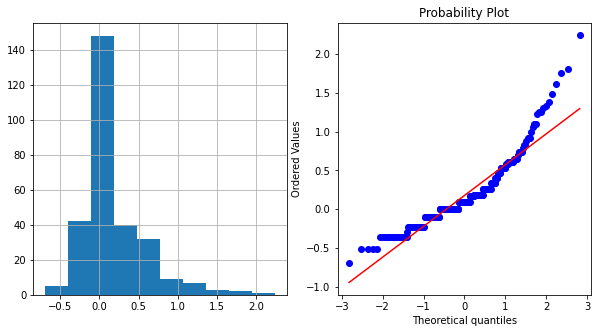

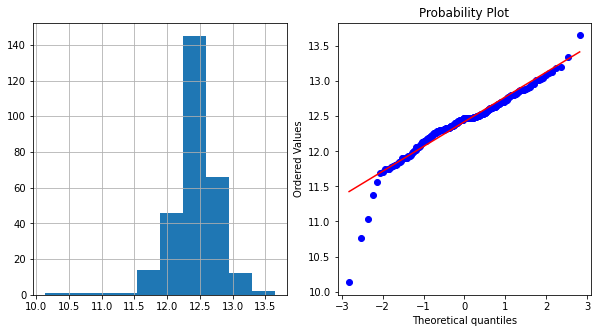

In [38]:
# LOGARITHMIC
Log_Trans=[]

# VARIABLE 1
import numpy as np
data['creatinine_phosphokinase_log']=np.log(data["creatinine_phosphokinase"])
plot_data(data,'creatinine_phosphokinase_log')
Log_Trans.append(data["creatinine_phosphokinase_log"].skew())

# VARIABLE 2
data['serum_creatinine_log']=np.log(data["serum_creatinine"])
plot_data(data,'serum_creatinine_log')
Log_Trans.append(data["serum_creatinine_log"].skew())

# VARIABLE 3
data['platelets_log']=np.log(data["platelets"])
plot_data(data,'platelets_log')
Log_Trans.append(data["platelets_log"].skew())

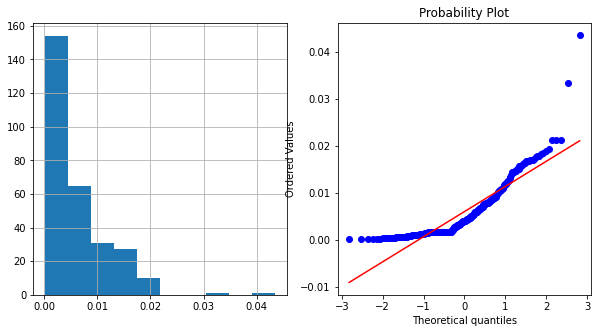

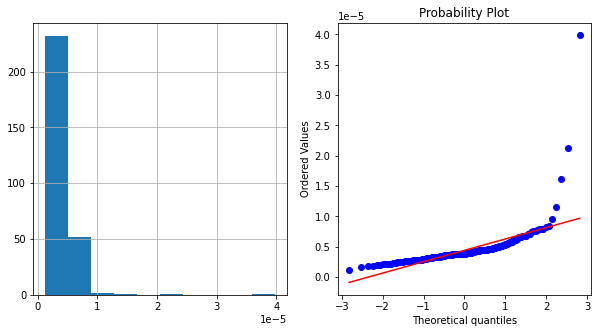

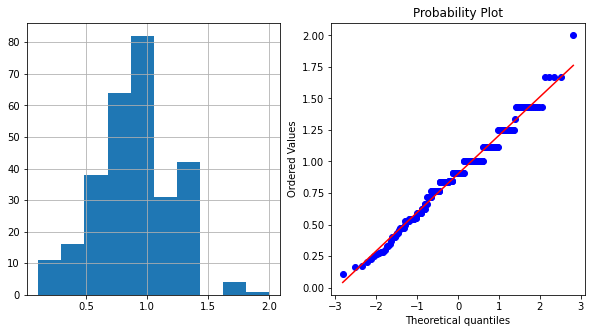

In [39]:
# RECIPROCAL TRANSFORMATION
rec_tran=[]

# VARIABLE 1
data['creatinine_phosphokinase_reciprocal']=1/(df["creatinine_phosphokinase"])
plot_data(data,'creatinine_phosphokinase_reciprocal')
rec_tran.append(data["creatinine_phosphokinase_reciprocal"].skew())

# VARIABLE 2
data['platelets_reciprocal']=1/(df["platelets"])
plot_data(data,'platelets_reciprocal')
rec_tran.append(data["platelets_reciprocal"].skew())

# VARIABLE 3
data['serum_creatinine_reciprocal']=1/(df["serum_creatinine"])
plot_data(data,'serum_creatinine_reciprocal')
rec_tran.append(data["serum_creatinine_reciprocal"].skew())

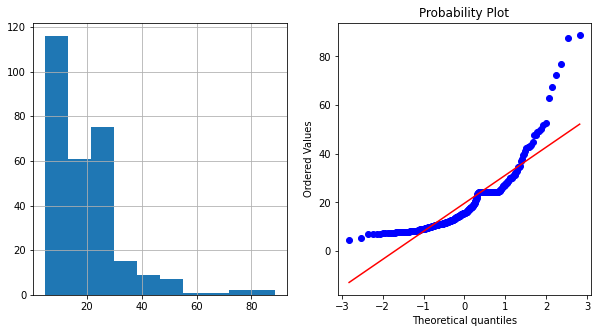

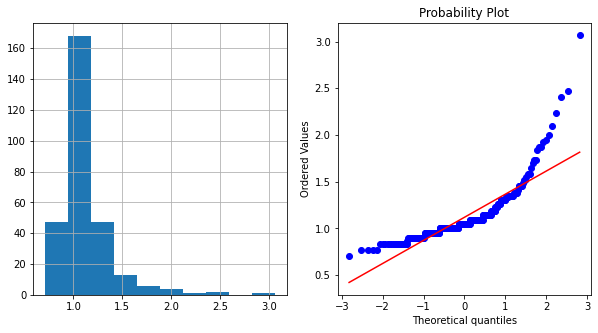

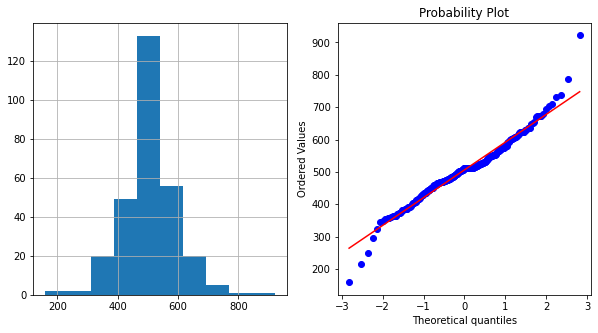

In [40]:
# SQUARE ROOT TRANSFORMATION
sqrt_tran=[]

# VARIABLE 1
data['creatinine_phosphokinase_square']=data["creatinine_phosphokinase"]**(1/2)
plot_data(data,'creatinine_phosphokinase_square')
sqrt_tran.append(data["creatinine_phosphokinase_square"].skew())

# VARIABLE 2
data['serum_creatinine_square']=data["serum_creatinine"]**(1/2)
plot_data(data,'serum_creatinine_square')
sqrt_tran.append(data["serum_creatinine_square"].skew())

# VARIABLE 3
data['platelets_square']=data["platelets"]**(1/2)
plot_data(data,'platelets_square')
sqrt_tran.append(data["platelets_square"].skew())

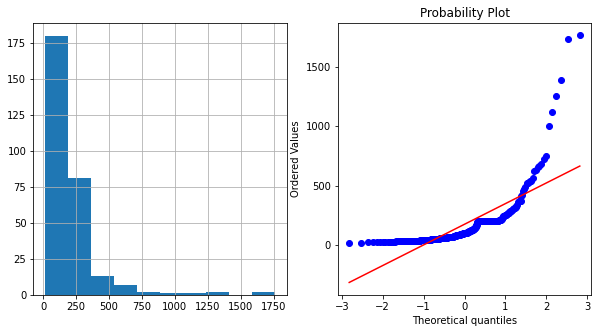

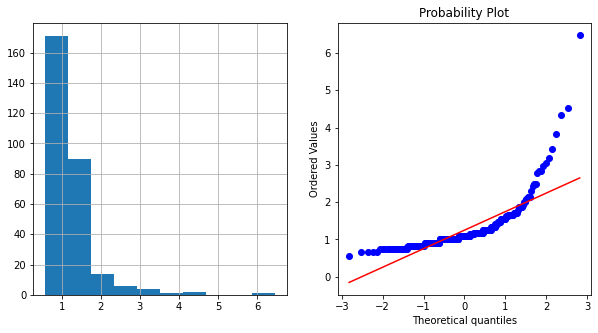

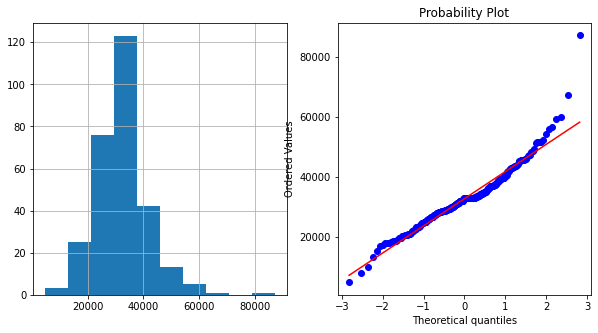

In [41]:
# EXPONENTIAL TRANSDORMATION
exp_tran=[]

# VARIABLE 1
data['creatinine_phosphokinase_exponential']=data["creatinine_phosphokinase"]**(1/1.2)
plot_data(data,'creatinine_phosphokinase_exponential')
exp_tran.append(data["creatinine_phosphokinase_exponential"].skew())

# VARIABLE 2
data['serum_creatinine_exponential']=data["serum_creatinine"]**(1/1.2)
plot_data(data,'serum_creatinine_exponential')
exp_tran.append(data["serum_creatinine_exponential"].skew())

# VARIABLE 3
data['platelets_exponential']=data["platelets"]**(1/1.2)
plot_data(data,'platelets_exponential')
exp_tran.append(data["platelets_exponential"].skew())

BOXCOX Transformation

T(Y)=(Y exp(λ)−1)/λ

where Y is the response variable and λ is the transformation parameter. λ varies from -5 to 5. In the transformation, all values of λ are considered and the optimal value for a given variable is selected

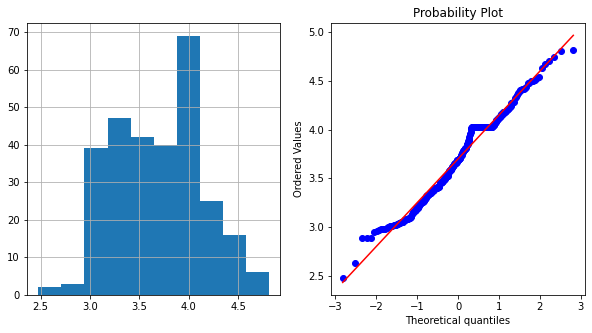

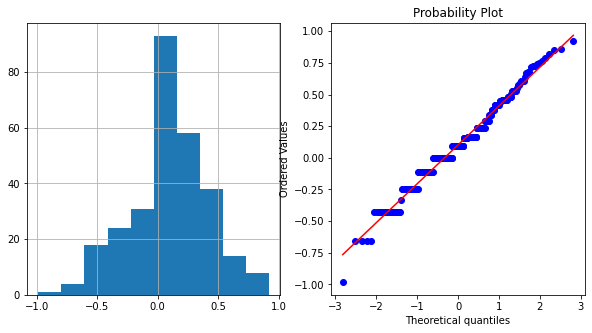

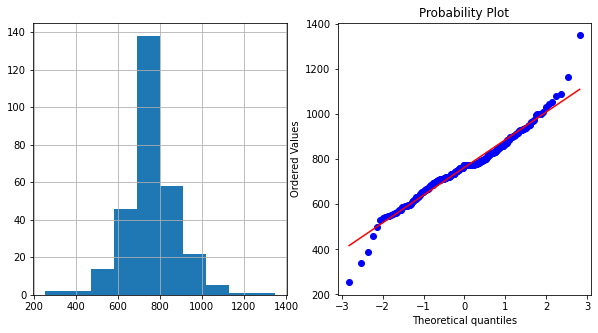

In [42]:
# BoxCox Transformation
boxcox_tran=[]

# VARIABLE 1
data['creatinine_phosphokinase_Boxcox'],parameters=stats.boxcox(data["creatinine_phosphokinase"])
plot_data(data,'creatinine_phosphokinase_Boxcox')
boxcox_tran.append(data["creatinine_phosphokinase_Boxcox"].skew())

# VARIABLE 2
data['serum_creatinine_Boxcox'],parameters=stats.boxcox(data["serum_creatinine"])
plot_data(data,'serum_creatinine_Boxcox')
boxcox_tran.append(data["serum_creatinine_Boxcox"].skew())

# VARIABLE 3
data['platelets_Boxcox'],parameters=stats.boxcox(data["platelets"])
plot_data(data,'platelets_Boxcox')
boxcox_tran.append(data["platelets_Boxcox"].skew())

In [43]:
# CONCLUSION
name = ['creatinine_phosphokinase', 'serum_creatinine', 'platelets']
results=pd.DataFrame({"name":name,'before_trans': before_Trans,
                      'Logarithmic transformation': Log_Trans,
                      'reciprocal transformatio': rec_tran,
                      "square root transformation":sqrt_tran,
                      "exponential transformation":exp_tran,
                      "boxcox transformation":boxcox_tran
                      })
display(results)

,name,before_trans,Logarithmic transformation,reciprocal transformatio,square root transformation,exponential transformation,boxcox transformation
0,creatinine_phosphokinase,4.852619,0.416232,1.911456,2.259576,3.989182,0.038532
1,serum_creatinine,4.629680,1.509754,8.258705,2.767201,3.933487,-0.005123
2,platelets,1.437016,-1.286414,0.054315,0.221134,1.026424,0.153955


In [44]:
# WE DECIDE USE BOXCOX
def boxcox(df,feature):
    df[str(feature)+"_Boxcox"],parameters=stats.boxcox(df[feature])
    plot_data(df,str(feature)+"_Boxcox")

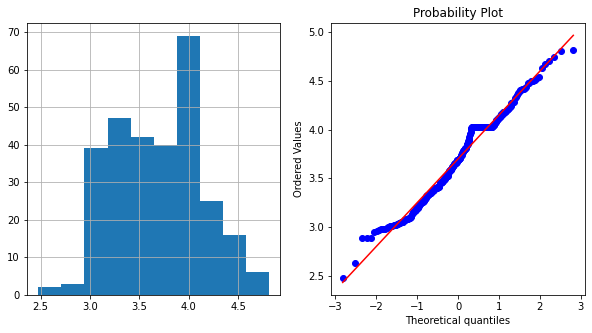

In [45]:
boxcox(df,"creatinine_phosphokinase")

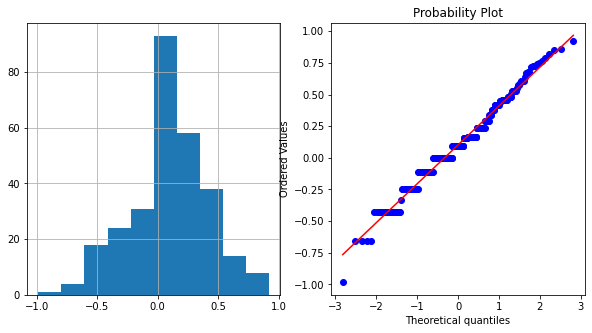

In [46]:
boxcox(df,"serum_creatinine")

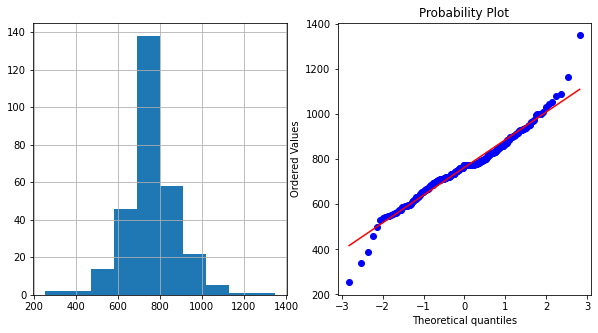

In [47]:
boxcox(df,"platelets")

In [48]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,creatinine_phosphokinase_Boxcox,serum_creatinine_Boxcox,platelets_Boxcox
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,4.025638,0.478943,776.442477
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,4.812379,0.091073,774.155955
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,3.457055,0.231885,614.694301
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,3.328958,0.478943,695.287977
4,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1,2.889637,0.530416,685.786862


## **Modeling STEP**

In [50]:
# Splitting dataset
X = data.drop(["DEATH_EVENT","creatinine_phosphokinase","serum_creatinine","platelets"], axis = 1)
y = data.DEATH_EVENT

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=11)

print("X Train:", X_train.shape)
print("X Test:", X_test.shape)
print("y Train:", y_train.shape)
print("y Test:", y_test.shape)
print("Data is ready!")

X Train: (231, 24)
X Test: (58, 24)
y Train: (231,)
y Test: (58,)
Data is ready!


In [60]:
# EVALUATION MODEL
# Build evaluation models
from sklearn.metrics import accuracy_score, confusion_matrix, auc

result_acc = []

def car_pred_model(model,model_name):
    # Training model
    model.fit(X_train,y_train)

    # Prediction
    y_pred = model.predict(X_test) 

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    result_acc.append(np.round(acc,2))
       
    # Printing results
    print("Accuracy :",np.round(acc,2))
    
    # Plotting Graphs 
    # Confusion Matrix
    cm = confusion_matrix(y_pred, y_test)
    df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
    plt.show()

Accuracy : 0.79


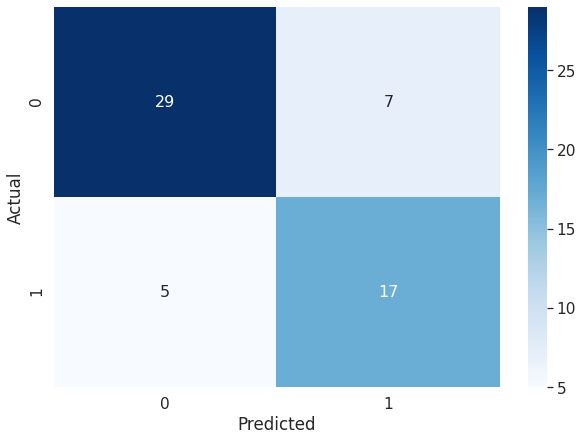

In [61]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
car_pred_model(log_reg, "Logistic Regression")

Accuracy : 0.59


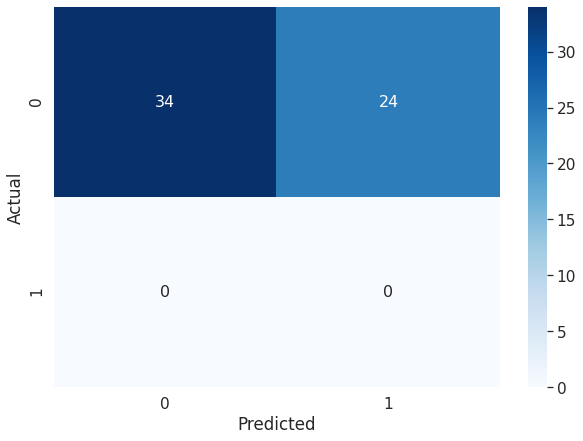

In [62]:
# SVM
from sklearn.svm import SVC
svm = SVC()
car_pred_model(svm, "SVM")

Accuracy : 0.78


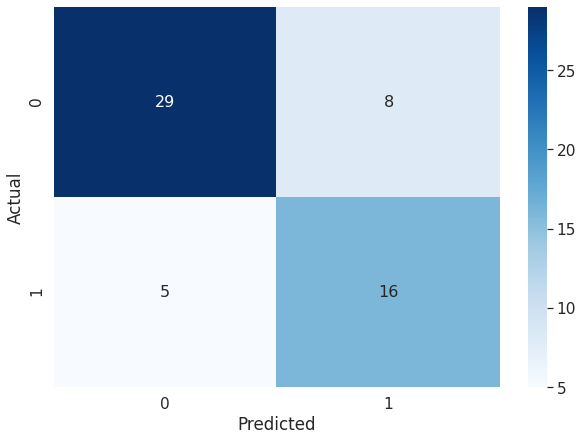

In [63]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(max_depth=7, random_state=25)
car_pred_model(random_forest_model, "Random Forest")

In [65]:
results = pd.DataFrame({"Model Result":result_acc, 
                        "Models":["LogisticRegression",
                                  "SVM","RandomForest"]})
results

,Model Result,Models
0,0.79,LogisticRegression
1,0.59,SVM
2,0.78,RandomForest


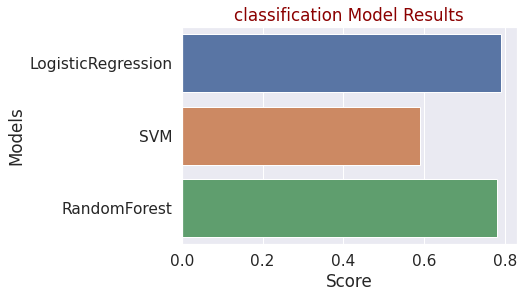

In [66]:
g = sns.barplot(y = results.Models, x =results["Model Result"])
g.set_xlabel("Score")
g.set_title("classification Model Results", color = "darkred")
plt.show()